In [1]:
from fastai.text import *
from sqlalchemy import create_engine

In [2]:
with open('psql_engine.txt') as f:
    psql = create_engine(f.read())
    
with open('lm_gpu/data_ru/tmp/itos.pkl', 'rb') as fru, open('lm_gpu/data_uk/tmp/itos.pkl', 'rb') as fuk:
    itos_ru = pickle.load(fru)
    itos_uk = pickle.load(fuk)

In [3]:
%%capture
bptt,em_sz,nh,nl,c = 70,400,1150,3,2
vs = len(itos_ru)
bs = 2

sigm = lambda x: 1 / (1 + np.exp(-x))
sigmv = np.vectorize(sigm)

m_pred = get_rnn_classifer(bptt, 25*70, 2, vs,
                           emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                           drops=[0,0],
                           layers=[em_sz*3, 50, c])

load_model(m_pred, 'classifiers/arg_2_mult_best54.h5')

m_pred.cuda()
m_pred.eval()

## each activation on small sample

In [59]:
# html_ids

to_check = '688276, 1731042, 2463925, 2493020, 938827, 1809868, 2889683, 290087, 1598581, 2495822, 2058441, 3019198'

In [60]:
check_ids = pd.read_sql(f'''
    select html_id, tokenized, ra_title, word_ids, lang
    from htmls
    where html_id in ({to_check});
    ''', psql)

In [61]:
ds_ru = TextDataset(check_ids.loc[check_ids.lang == 'ru'].word_ids.values, check_ids.loc[check_ids.lang == 'ru'].html_id.values)
dl_ru = DataLoader(ds_ru, 24, transpose=True, num_workers=3, pad_idx=1)

In [8]:
result = m_pred(V(next(iter(dl_ru))[0]))

preds_ru = sigmv(result[0].data.cpu().numpy())
ru_states = []
for i in range(len(ds_ru)):
    ru_states.append(result[-1][-1][:, i, :].data.cpu().numpy())
    
del result

In [9]:
BOS = 'xbos'
FLD = 'xbod'

def split_tok(text):
    return' \n '.join([p.replace('\n', f' {BOS} ')
                       for p in text.strip().split('\n\n')]
                     ).split(' ')

In [10]:
splitted_ru = (f'\n{BOS} {FLD} 1 ' + check_ids.loc[check_ids.lang == 'ru'].tokenized
              ).apply(split_tok).values.tolist()

In [11]:
states_of_news = {}
for splited, states, preds, html_id in zip(splitted_ru, ru_states, preds_ru, ds_ru.y):
    states_per_word = np.hstack([np.array(splited)[:, None], states[-len(splited):]]).tolist()
    states_of_news[str(html_id)] = {
        'states_per_word': states_per_word,
        'pred_emo': preds[0],
        'pred_arg': preds[1],
    }
    

In [19]:
for k, v in states_of_news.items():
    with open(f'states_data/{k}.json', 'w') as f:
        json.dump(v, f, ensure_ascii=False, allow_nan=False)

In [28]:
check_ids.loc[check_ids.lang == 'ru', ['html_id', 'ra_title']
             ].to_json('states_data/file_index.json', orient='records', force_ascii=False)

## Regression to find LM vector weights

In [4]:
ru_ann = pd.read_csv('ru_annotation.csv')
ru_ann = ru_ann.loc[ru_ann.is_other == 0].copy().drop(['is_other'], axis=1)
ru_ids = ', '.join(ru_ann.html_id.astype(str).values)

ru_ann = ru_ann.merge(pd.read_sql(f'''
    select html_id, word_ids
    from htmls
    where html_id in ({ru_ids})
      and word_ids notnull
    ''', psql), on='html_id', how='inner')

ru_ann = ru_ann.loc[ru_ann.word_ids.apply(lambda l: len(l) < 1200)].copy()
del ru_ids

In [5]:
ds_ru = TextDataset(ru_ann.word_ids.values, ru_ann.html_id.values)
dl_ru = DataLoader(ds_ru, bs, transpose=True, num_workers=3, pad_idx=1)

In [6]:
def pool(x, bs, is_max):
    f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
    return f(x.permute(1,2,0), (1,)).view(bs,-1)

final_outputs = {}
for x, y in tqdm(dl_ru):
    m_pred.eval()
    m_pred.reset()
    output = m_pred[0](V(x))[-1][-1]
    avgpool = pool(output, bs, False)
    mxpool = pool(output, bs, True)
    x = torch.cat([output[-1], mxpool, avgpool], 1).data.cpu().numpy()
    y = y.cpu().numpy()
    final_outputs = {**final_outputs, **dict(zip(y, x))}

100%|██████████| 2977/2977 [15:53<00:00,  3.91it/s]


In [7]:
ru_ann['pred_vec'] = ru_ann.html_id.apply(lambda i: final_outputs[i])

In [8]:
ru_ann.to_json('ru_ann_states.jl', lines=True, orient=ent='records')

In [9]:
ru_ann_trn = ru_ann.loc[ru_ann.trn_val == 'trn'].copy().drop('trn_val', axis=1)
ru_ann_val = ru_ann.loc[ru_ann.trn_val == 'val'].copy().drop('trn_val', axis=1)

### lr

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import *

#### On concat pulled vector

In [44]:
lr_emo = SGDClassifier(loss='log', penalty='l1', alpha=0.001, verbose=True)
lr_arg = SGDClassifier(loss='log', penalty='l1', alpha=0.001, verbose=True)

In [45]:
lr_emo.fit(np.vstack(ru_ann_trn.pred_vec.values), ru_ann_trn.is_emo)
lr_arg.fit(np.vstack(ru_ann_trn.pred_vec.values), ru_ann_trn.is_arg)

/home/nadiiaromanenko/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


-- Epoch 1
Norm: 155.04, NNZs: 239, Bias: -2.791472, T: 4742, Avg. loss: 4.436486
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 155.32, NNZs: 170, Bias: -1.468586, T: 9484, Avg. loss: 0.766981
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 155.54, NNZs: 137, Bias: -1.508049, T: 14226, Avg. loss: 0.533877
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 155.73, NNZs: 121, Bias: -0.791440, T: 18968, Avg. loss: 0.463189
Total training time: 0.31 seconds.
-- Epoch 5
Norm: 155.89, NNZs: 108, Bias: -0.697880, T: 23710, Avg. loss: 0.437990
Total training time: 0.38 seconds.


/home/nadiiaromanenko/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


-- Epoch 1
Norm: 105.49, NNZs: 71, Bias: -0.996859, T: 4742, Avg. loss: 1.123768
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 106.52, NNZs: 47, Bias: -1.586417, T: 9484, Avg. loss: 0.190481
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 106.90, NNZs: 38, Bias: -2.217896, T: 14226, Avg. loss: 0.172096
Total training time: 0.22 seconds.
-- Epoch 4
Norm: 107.12, NNZs: 36, Bias: -2.498441, T: 18968, Avg. loss: 0.168513
Total training time: 0.29 seconds.
-- Epoch 5
Norm: 107.26, NNZs: 34, Bias: -2.528608, T: 23710, Avg. loss: 0.168448
Total training time: 0.37 seconds.


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [48]:
emo_params = dict(
    y_pred=lr_emo.predict(np.vstack(ru_ann_val.pred_vec.values)),
    y_true=ru_ann_val.is_emo,
    labels=[1,0]
)

arg_params = dict(
    y_pred=lr_arg.predict_proba(np.vstack(ru_ann_val.pred_vec.values))[:, 1] > 0.05,
    y_true=ru_ann_val.is_arg,
    labels=[1,0]
)

def print_metrics(params, s):
    print(s)
    print(classification_report(**params))
    cm = confusion_matrix(**params)
    print(cm / cm.sum(1)[:, None])
    print(cm)
    
print_metrics(emo_params, 'EMO')
print_metrics(arg_params, 'ARG')

EMO
              precision    recall  f1-score   support

           1       0.32      0.79      0.45       164
           0       0.96      0.74      0.83      1048

   micro avg       0.74      0.74      0.74      1212
   macro avg       0.64      0.76      0.64      1212
weighted avg       0.87      0.74      0.78      1212

[[0.78659 0.21341]
 [0.26431 0.73569]]
[[129  35]
 [277 771]]
ARG
              precision    recall  f1-score   support

           1       0.28      0.67      0.39       203
           0       0.91      0.65      0.76      1009

   micro avg       0.66      0.66      0.66      1212
   macro avg       0.59      0.66      0.58      1212
weighted avg       0.80      0.66      0.70      1212

[[0.66502 0.33498]
 [0.34589 0.65411]]
[[135  68]
 [349 660]]


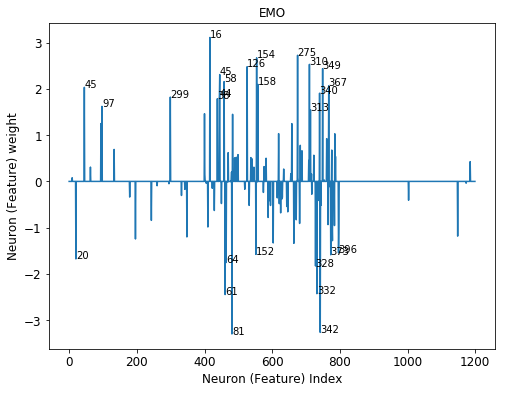

In [49]:
plt.figure(figsize=(8,6))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot(range(1200), lr_emo.coef_.T)
for i, c in enumerate(lr_emo.coef_.T):
    if abs(c) > 1.5:
        plt.text(i, c, f'{i % 400}')
plt.xlabel('Neuron (Feature) Index', size=12)
plt.ylabel('Neuron (Feature) weight', size=12)
plt.title('EMO')
plt.show()

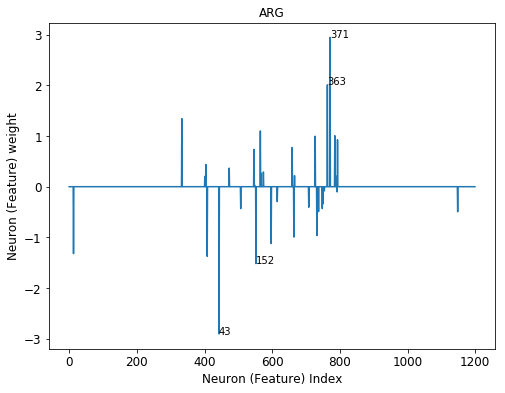

In [50]:
plt.figure(figsize=(8,6))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot(range(1200), lr_arg.coef_.T)
for i, c in enumerate(lr_arg.coef_.T):
    if abs(c) > 1.5:
        plt.text(i, c, f'{i % 400}')
plt.xlabel('Neuron (Feature) Index', size=12)
plt.ylabel('Neuron (Feature) weight', size=12)
plt.title('ARG')
plt.show()

#### on last state only

In [51]:
lr_emo = SGDClassifier(loss='log', penalty='l1', alpha=0.001, verbose=True)
lr_arg = SGDClassifier(loss='log', penalty='l1', alpha=0.001, verbose=True)

lr_emo.fit(np.vstack(ru_ann_trn.pred_vec.values)[:, :400], ru_ann_trn.is_emo)
lr_arg.fit(np.vstack(ru_ann_trn.pred_vec.values)[:, :400], ru_ann_trn.is_arg)

/home/nadiiaromanenko/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nadiiaromanenko/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


-- Epoch 1
Norm: 38.38, NNZs: 44, Bias: -0.636732, T: 4742, Avg. loss: 0.552576
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 39.34, NNZs: 41, Bias: -0.832773, T: 9484, Avg. loss: 0.496599
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 39.79, NNZs: 38, Bias: -0.728452, T: 14226, Avg. loss: 0.491879
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 40.09, NNZs: 38, Bias: -0.800479, T: 18968, Avg. loss: 0.490515
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 40.32, NNZs: 38, Bias: -0.659575, T: 23710, Avg. loss: 0.489373
Total training time: 0.15 seconds.
-- Epoch 1
Norm: 24.15, NNZs: 12, Bias: -3.529294, T: 4742, Avg. loss: 0.211170
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 24.56, NNZs: 10, Bias: -2.777162, T: 9484, Avg. loss: 0.196459
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 24.77, NNZs: 9, Bias: -3.163108, T: 14226, Avg. loss: 0.195126
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 24.91, NNZs: 8, Bias: -2.987866, T: 18968, Avg. loss: 0.1945

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [54]:
emo_params = dict(
    y_pred=lr_emo.predict(np.vstack(ru_ann_val.pred_vec.values)[:, :400]),
    y_true=ru_ann_val.is_emo,
    labels=[1,0]
)

arg_params = dict(
    y_pred=lr_arg.predict_proba(np.vstack(ru_ann_val.pred_vec.values)[:, :400])[:, 1] > 0.1,
    y_true=ru_ann_val.is_arg,
    labels=[1,0]
)

def print_metrics(params, s):
    print(s)
    print(classification_report(**params))
    cm = confusion_matrix(**params)
    print(cm / cm.sum(1)[:, None])
    print(cm)
    
print_metrics(emo_params, 'EMO')
print_metrics(arg_params, 'ARG')

EMO
              precision    recall  f1-score   support

           1       0.41      0.46      0.43       164
           0       0.91      0.89      0.90      1048

   micro avg       0.84      0.84      0.84      1212
   macro avg       0.66      0.68      0.67      1212
weighted avg       0.85      0.84      0.84      1212

[[0.46341 0.53659]
 [0.10592 0.89408]]
[[ 76  88]
 [111 937]]
ARG
              precision    recall  f1-score   support

           1       0.56      0.02      0.05       203
           0       0.84      1.00      0.91      1009

   micro avg       0.83      0.83      0.83      1212
   macro avg       0.70      0.51      0.48      1212
weighted avg       0.79      0.83      0.76      1212

[[0.02463 0.97537]
 [0.00396 0.99604]]
[[   5  198]
 [   4 1005]]


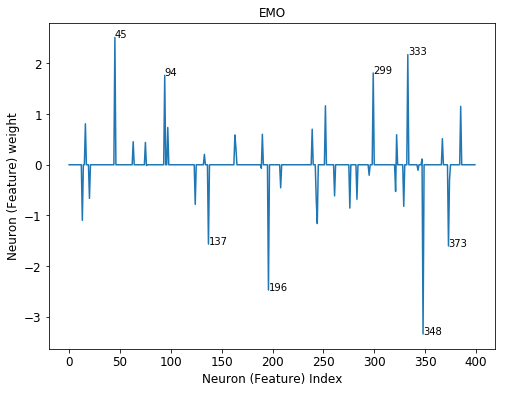

In [53]:
plt.figure(figsize=(8,6))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot(range(400), lr_emo.coef_.T)
for i, c in enumerate(lr_emo.coef_.T):
    if abs(c) > 1.5:
        plt.text(i, c, f'{i % 400}')
plt.xlabel('Neuron (Feature) Index', size=12)
plt.ylabel('Neuron (Feature) weight', size=12)
plt.title('EMO')
plt.show()

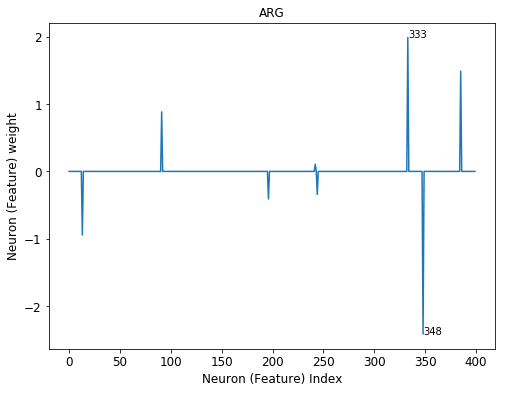

In [56]:
plt.figure(figsize=(8,6))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot(range(400), lr_arg.coef_.T)
for i, c in enumerate(lr_arg.coef_.T):
    if abs(c) > 1.5:
        plt.text(i, c, f'{i % 400}')
plt.xlabel('Neuron (Feature) Index', size=12)
plt.ylabel('Neuron (Feature) weight', size=12)
plt.title('ARG')
plt.show()